### **Project work for the course Artificial Intelligence in Industry at University of Bologna - Master's degree in Artificial Intelligence**

#### Stefano Poggi Cavalletti - 0000982439 - stefano.poggi2@studio.unibo.it

The aim of this project is to perform anomaly detection in time series, in particular on healthcare datasets related to ECG signals, which are recordings of the heart's electrical activity. To perform this task, we will use two available datasets containing ECG data of real patients: ECG5000 and MIT-BIH Arrhythmia Database. In order to be able to distinguish a normal signal from an anomaly, we will use different techniques, like autoencoders and LSTM. In the final part, we will perform classification task.

The ECG5000 dataset is available in the UCR Time Series Classification archive and contains a set of 5000 univariate time series (d_x = 1) with 140 timesteps (T = 140). Each sequence corresponds to a single heartbeat from a single patient. Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. The frequency is 60-100 per minute and the duration is 0.6–1 second.

Five classes are annotated, corresponding to the following labels: 

*   Normal (N)
*   R-on-T Premature Ventricular Contraction (R-on-T 
PVC)
*   Premature Ventricular Contraction (PVC)
*   Supra-ventricular Premature or Ectopic Beat (SP or EB)
*   Unclassified Beat (UB)





In [76]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import json
import copy

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model
#import torch
#from torch import nn, optim

#import torch.nn.functional as F

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)

In [77]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:

# Configuration
anomaly_color = 'sandybrown'
prediction_color = 'yellowgreen'
training_color = 'yellowgreen'
validation_color = 'gold'
test_color = 'coral'
figsize=(9, 3)


def plot_series(data, labels=None,
                    windows=None,
                    predictions=None,
                    highlights=None,
                    val_start=None,
                    test_start=None,
                    threshold=None,
                    figsize=figsize):
    # Open a new figure
    plt.close('all')
    plt.figure(figsize=figsize)
    # Plot data
    plt.plot(data.index, data.values, zorder=0)
    # Rotated x ticks
    plt.xticks(rotation=45)
    # Plot labels
    if labels is not None:
        plt.scatter(labels.values, data.loc[labels],
                    color=anomaly_color, zorder=2)
    # Plot windows
    if windows is not None:
        for _, wdw in windows.iterrows():
            plt.axvspan(wdw['begin'], wdw['end'],
                        color=anomaly_color, alpha=0.3, zorder=1)
    
    # Plot training data
    if val_start is not None:
        plt.axvspan(data.index[0], val_start,
                    color=training_color, alpha=0.1, zorder=-1)
    if val_start is None and test_start is not None:
        plt.axvspan(data.index[0], test_start,
                    color=training_color, alpha=0.1, zorder=-1)
    if val_start is not None:
        plt.axvspan(val_start, test_start,
                    color=validation_color, alpha=0.1, zorder=-1)
    if test_start is not None:
        plt.axvspan(test_start, data.index[-1],
                    color=test_color, alpha=0.3, zorder=0)
    # Predictions
    if predictions is not None:
        plt.scatter(predictions.values, data.loc[predictions],
                    color=prediction_color, alpha=.4, zorder=3)
    # Plot threshold
    if threshold is not None:
        plt.plot([data.index[0], data.index[-1]], [threshold, threshold], linestyle=':', color='tab:red')
    plt.tight_layout()


def plot_autocorrelation(data, max_lag=100, figsize=figsize):
    # Open a new figure
    plt.close('all')
    plt.figure(figsize=figsize)
    # Autocorrelation plot
    pd.plotting.autocorrelation_plot(data)
    # Customized x limits
    plt.xlim(0, max_lag)
    # Rotated x ticks
    plt.xticks(rotation=45)
    plt.tight_layout()


def plot_histogram(data, bins=10, vmin=None, vmax=None, figsize=figsize):
    # Build a new figure
    plt.close('all')
    plt.figure(figsize=figsize)
    # Plot a histogram
    plt.hist(data, density=True, bins=bins)
    # Update limits
    lims = plt.xlim()
    if vmin is not None:
        lims = (vmin, lims[1])
    if vmax is not None:
        lims = (lims[0], vmax)
    plt.xlim(lims)
    plt.tight_layout()


def plot_histogram2d(xdata, ydata, bins=10, figsize=figsize):
    # Build a new figure
    plt.close('all')
    plt.figure(figsize=figsize)
    # Plot a histogram
    plt.hist2d(xdata, ydata, density=True, bins=bins)
    plt.tight_layout()

def get_pred(signal, thr):
    return pd.Series(signal.index[signal >= thr])


def get_metrics(pred, labels, windows):
    tp = [] # True positives
    fp = [] # False positives
    fn = [] # False negatives
    advance = [] # Time advance, for true positives
    # Loop over all windows
    used_pred = set()
    for idx, w in windows.iterrows():
        # Search for the earliest prediction
        pmin = None
        for p in pred:
            if p >= w['begin'] and p < w['end']:
                used_pred.add(p)
                if pmin is None or p < pmin:
                    pmin = p
        # Compute true pos. (incl. advance) and false neg.
        l = labels[idx]
        if pmin is None:
            fn.append(l)
        else:
            tp.append(l)
            advance.append(l-pmin)
    # Compute false positives
    for p in pred:
        if p not in used_pred:
            fp.append(p)
    # Return all metrics as pandas series
    return pd.Series(tp, dtype='datetime64[ns]'), \
            pd.Series(fp, dtype='datetime64[ns]'), \
            pd.Series(fn, dtype='datetime64[ns]'), \
            pd.Series(advance)


class ADSimpleCostModel:

    def __init__(self, c_alrm, c_missed, c_late):
        self.c_alrm = c_alrm
        self.c_missed = c_missed
        self.c_late = c_late

    def cost(self, signal, labels, windows, thr):
        # Obtain predictions
        pred = get_pred(signal, thr)
        # Obtain metrics
        tp, fp, fn, adv = get_metrics(pred, labels, windows)
        # Compute the cost
        adv_det = [a for a in adv if a.total_seconds() <= 0]
        cost = self.c_alrm * len(fp) + \
           self.c_missed * len(fn) + \
           self.c_late * (len(adv_det))
        return cost


def opt_thr(signal, labels, windows, cmodel, thr_range):
    costs = [cmodel.cost(signal, labels, windows, thr)
            for thr in thr_range]
    costs = np.array(costs)
    best_idx = np.argmin(costs)
    return thr_range[best_idx], costs[best_idx]


def sliding_window_1D(data, wlen):
    assert(len(data.columns) == 1)
    # Get shifted columns
    m = len(data)
    lc = [data.iloc[i:m-wlen+i+1].values for i in range(0, wlen)]
    # Stack
    wdata = np.hstack(lc)
    # Wrap
    wdata = pd.DataFrame(index=data.index[wlen-1:],
            data=wdata, columns=range(wlen))

In [79]:
# Import the dataset files

ecg_train_file = 'ECG5000_TRAIN.csv'
ecg_test_file = 'ECG5000_TEST.csv'


train_data = pd.read_csv(ecg_train_file)
test_data = pd.read_csv(ecg_test_file)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

We'll combine the training and test data into a single data frame.

In [80]:
df = df_train.append(df_test)

In [81]:
df = df.drop(labels='id', axis=1)

In [82]:
new_columns = list(df.columns)
# target for classification
new_columns[-1] = 'target'
df.columns = new_columns

In [83]:
df

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t132,t133,t134,t135,t136,t137,t138,t139,t140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,4
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,2
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,2
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,2


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [84]:
normal_class = 1
class_names = ['Normal','R on T','PVC','SP','UB']

### Exploratory Data Analysis

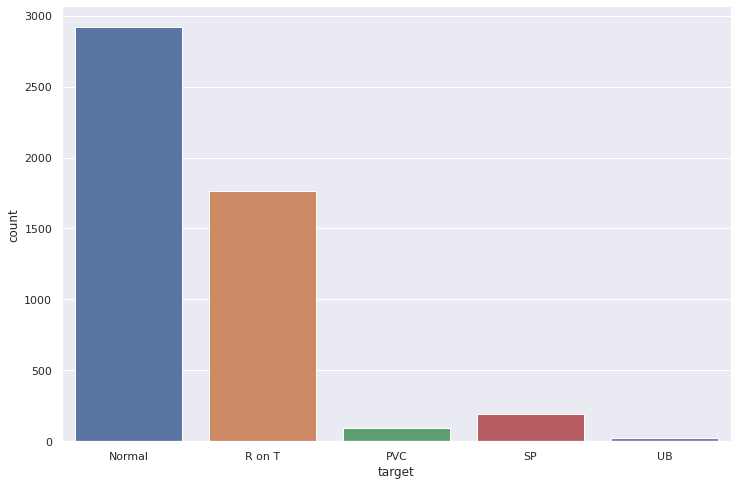

In [85]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

As we can see, classes are very unbalanced

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df.values,
                                                    df.values[:,-1], 
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [87]:
X_train[:,:-1]

array([[-0.11172644, -0.4649814 , -0.73892728, ..., -4.4273801 ,
        -5.2936242 , -3.7814352 ],
       [-0.1068843 , -0.5367486 , -0.99273862, ..., -3.0855403 ,
        -3.2976182 , -3.0241297 ],
       [-2.5369338 , -4.460064  , -4.3683577 , ...,  0.98888244,
         1.407983  ,  0.88475093],
       ...,
       [-1.0320965 , -2.8119009 , -3.5887058 , ...,  1.5680471 ,
         1.7765205 ,  0.75066935],
       [-1.5925409 , -2.4613697 , -2.5241322 , ..., -1.0776759 ,
        -0.70754117,  0.35401601],
       [-1.9455858 , -3.8405188 , -3.9946828 , ...,  0.95197929,
         0.88314532, -1.3660438 ]])

In [88]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(X_train[:,:-1])    

In [89]:
X_train[:, :-1] = data_scaled.transform(X_train[:, :-1])
X_test[:, :-1] = data_scaled.transform(X_test[:, :-1])

The normal class, has by far, the most examples. This is great because we'll use it to train our model.
Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [90]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

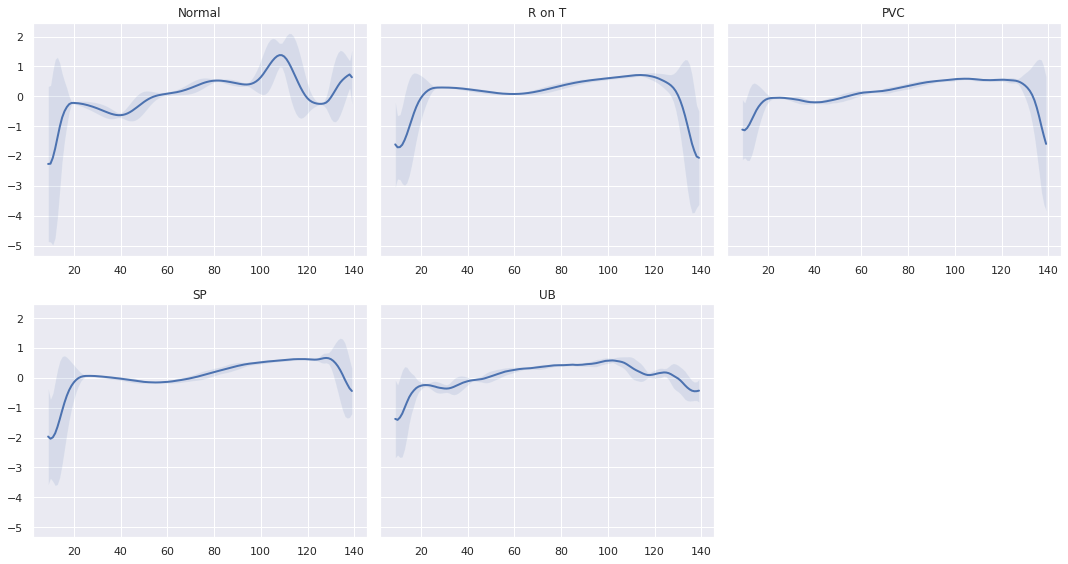

In [91]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(15, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## Autoencoder

 The Autoencoder's job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.
In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.
To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.
Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.

Anomaly Detection in ECG Data
We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data:

Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [92]:
X_train

array([[0.53813398, 0.59585633, 0.57441253, ..., 0.0569781 , 0.17124168,
        2.        ],
       [0.53857438, 0.58850356, 0.54122911, ..., 0.25063599, 0.22736195,
        2.        ],
       [0.317557  , 0.18654775, 0.09989901, ..., 0.70718614, 0.51703033,
        1.        ],
       ...,
       [0.45442466, 0.35540716, 0.20183108, ..., 0.74294265, 0.50709418,
        1.        ],
       [0.40345124, 0.39132017, 0.34101396, ..., 0.50193227, 0.47770011,
        2.        ],
       [0.37134117, 0.25002207, 0.14875345, ..., 0.65626497, 0.35023474,
        1.        ]])

In [93]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [94]:
normal_X_train = df_train[df_train.iloc[:,-1] == 1].drop(columns=df_train.columns[-1], axis=1).values
normal_X_train.shape

(2333, 140)

In [95]:
normal_X_test = df_test[df_test.iloc[:,-1] == 1].drop(columns=df_test.columns[-1], axis=1).values
normal_X_test.shape

(586, 140)

We'll merge all other classes and mark them as anomalies:

In [96]:
anomaly_X_train = df_train[df_train.iloc[:,-1] > 1].drop(columns=df_train.columns[-1], axis=1).values
anomaly_X_train.shape

(1667, 140)

In [97]:
anomaly_X_test = df_test[df_test.iloc[:,-1] > 1].drop(columns=df_test.columns[-1], axis=1).values
anomaly_X_test.shape

(414, 140)

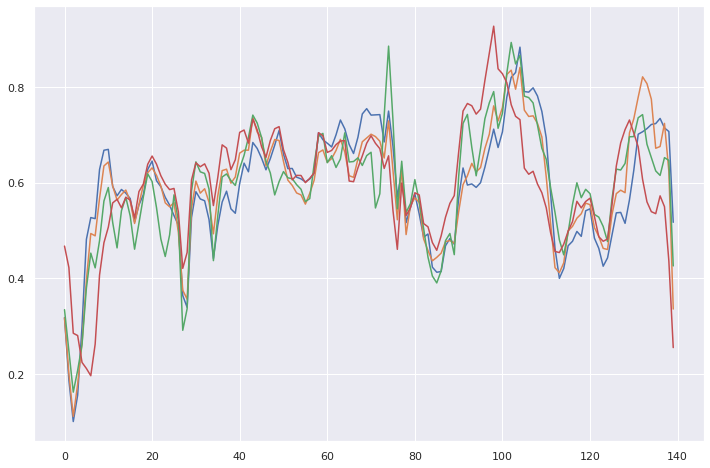

In [98]:
plt.figure(figsize=(12,8)) 
plt.plot(normal_X_train[0])
plt.plot(normal_X_train[1])
plt.plot(normal_X_train[2])
plt.plot(normal_X_train[3])

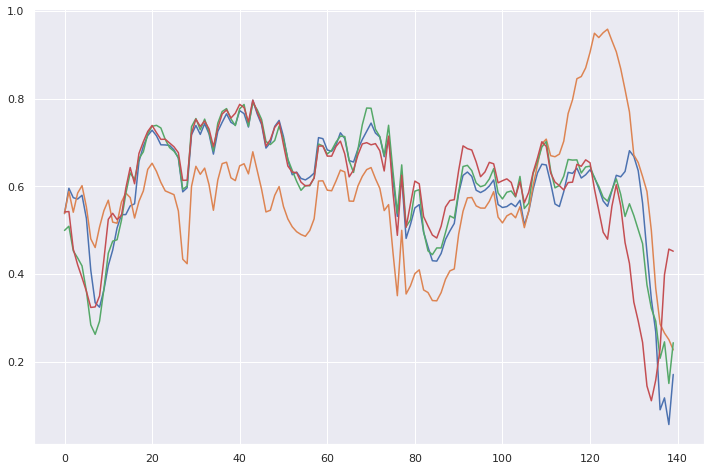

In [99]:
plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_train[0])
plt.plot(anomaly_X_train[1])
plt.plot(anomaly_X_train[2])
plt.plot(anomaly_X_train[3])

In [100]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [101]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=3,
                    mode='min',)

model.compile(optimizer='adam', loss='mae')

In [102]:
history = model.fit(normal_X_train, normal_X_train, 
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_train[:,1:], X_train[:,1:]),
                    callbacks=[early_stopping])

Epoch 1/100
19/19 [==============================] - 1s 10ms/step - loss: 0.1120 - val_loss: 0.1076
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0658 - val_loss: 0.0961
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0493 - val_loss: 0.0944
Epoch 4/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0466 - val_loss: 0.0940
Epoch 5/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0458 - val_loss: 0.0929
Epoch 6/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0443 - val_loss: 0.0904
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0412 - val_loss: 0.0870
Epoch 8/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0387 - val_loss: 0.0840
Epoch 9/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0374 - val_loss: 0.0838
Epoch 10/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0831
Epoch 11

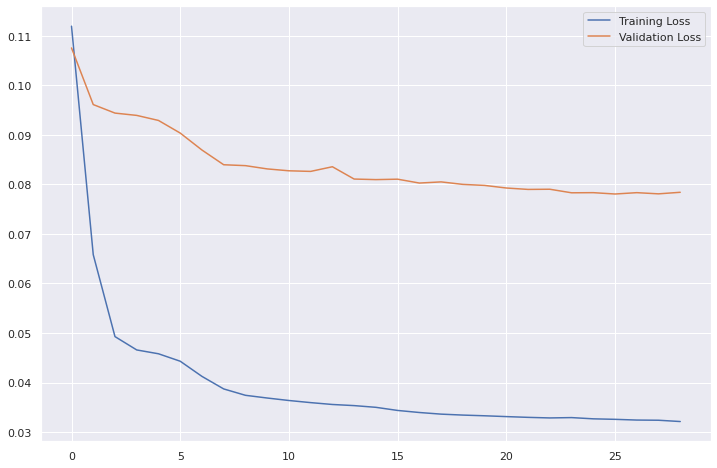

In [103]:
plt.figure(figsize=(12,8)) 
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

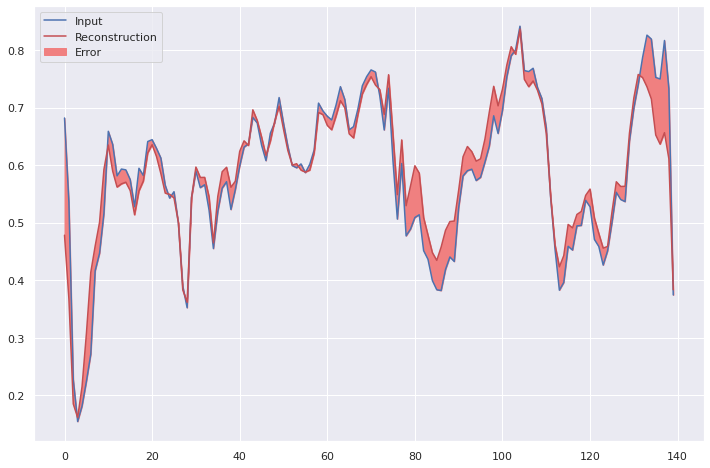

In [104]:
encoded_data = model.encoder(normal_X_test).numpy()
decoded_data = model.decoder(encoded_data).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(normal_X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

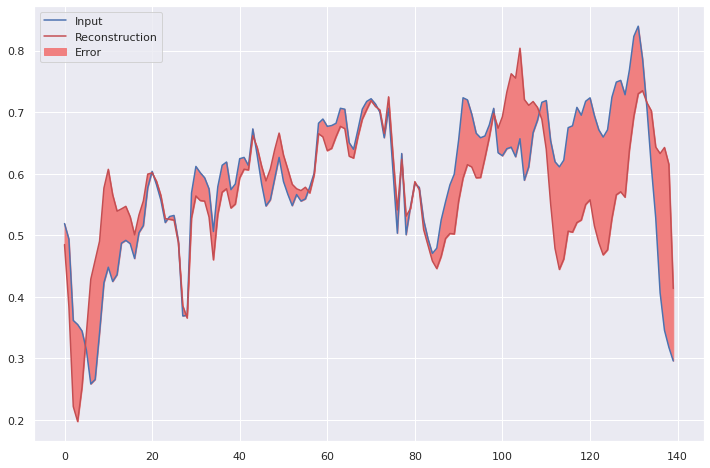

In [105]:
encoded_data = model.encoder(anomaly_X_test).numpy()
decoded_data = model.decoder(encoded_data).numpy()

plt.figure(figsize=(12,8)) 
plt.plot(anomaly_X_test[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomaly_X_test[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Finding threshold

As we can see, the normal data is fitted pretty accurately, whilst the abnormal data does not really copy the original data.

And that's what we are focusing at. We can now compute the mean square error mse or mean absolute error mae of the normal and abnormal data, plot their distribution and based on that decide where the threshold should be, so let's get into it!

In [106]:
reconstruction = model.predict(normal_X_train)
train_loss = tf.keras.losses.mse(reconstruction, normal_X_train) 

73/73 [==============================] - 0s 974us/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal train data')]

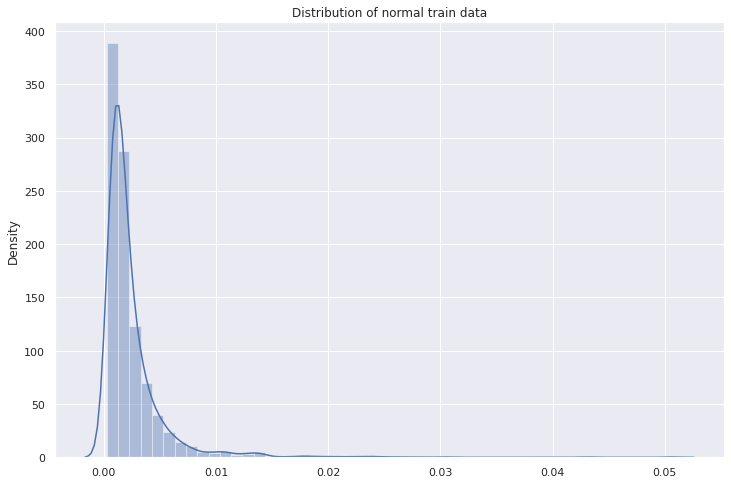

In [107]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(train_loss, bins=50, kde=True, ax=ax).set(title='Distribution of normal train data')

In [108]:
mean_normal = np.mean(train_loss)

std_normal = np.std(train_loss)

In [109]:
threshold = mean_normal + 2*std_normal
print("Threshold: ", threshold)

Threshold:  0.008494243740704165


## Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:
- If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal test data

In [110]:
reconstruction_test = model.predict(normal_X_test)
test_loss_normal = tf.keras.losses.mse(reconstruction_test, normal_X_test) 

19/19 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of normal test data')]

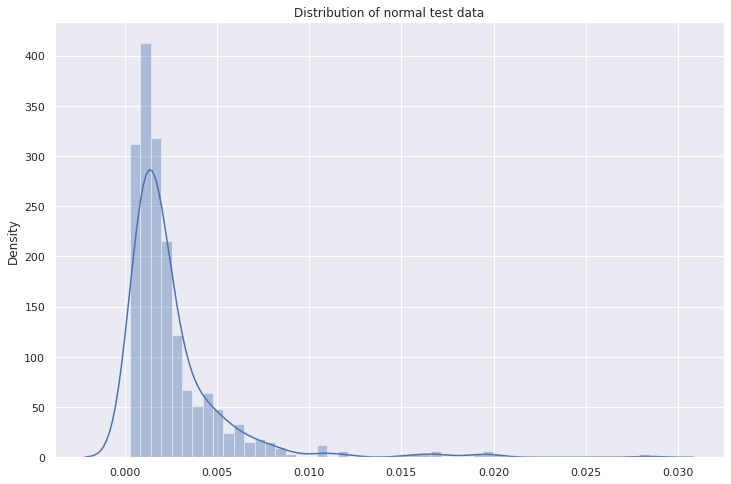

In [111]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_normal, bins=50, kde=True, ax=ax).set(title='Distribution of normal test data')

In [112]:
correct = [l <= threshold for l in test_loss_normal.numpy()]
print(f'Correct normal predictions: {np.count_nonzero(correct)}/{len(normal_X_test)}')

Correct normal predictions: 567/586


### Anomalous test data

In [113]:
reconstruction_anomalies = model.predict(anomaly_X_test)
test_loss_anomalies = tf.keras.losses.mse(reconstruction_anomalies, anomaly_X_test)

13/13 [==============================] - 0s 1ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Distribution of anomalous test data')]

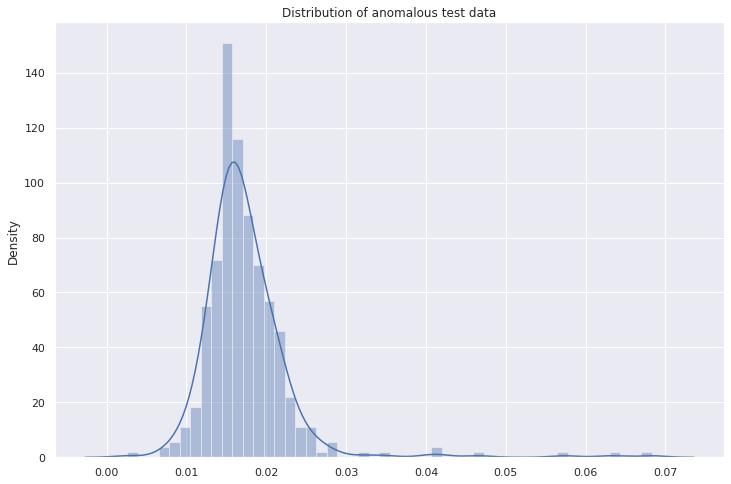

In [114]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(test_loss_anomalies, bins=50, kde=True, ax=ax).set(title='Distribution of anomalous test data')

In [115]:
correct = [l > threshold for l in test_loss_anomalies.numpy()]
print(f'Correct anomaly predictions: {np.count_nonzero(correct)}/{len(anomaly_X_test)}')

Correct anomaly predictions: 410/414


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


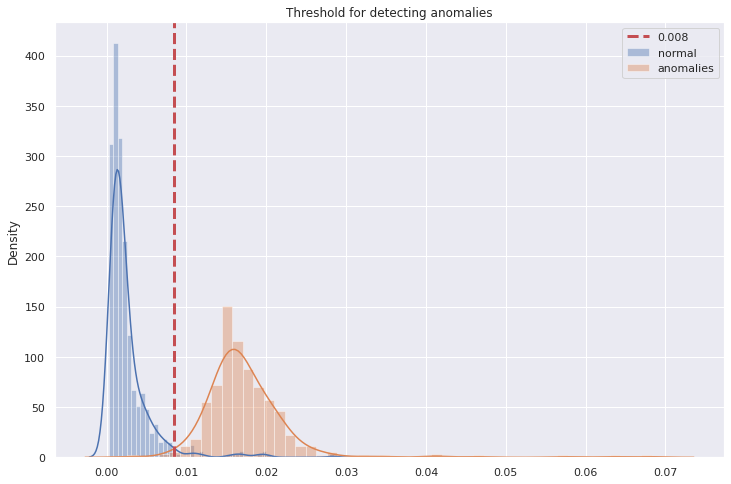

In [116]:
sns.set(rc={'figure.figsize':(12,8)})

# plot histograms of normal and abnormal data

sns.distplot(test_loss_normal.numpy(), bins=50, label='normal')
sns.distplot(test_loss_anomalies.numpy(), bins=50, label='anomalies')

# plot a vertical line, which displays the threshold

plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

# add a legend and title

plt.legend(loc='upper right')
plt.title('Threshold for detecting anomalies')
plt.show()

## Confusion matrix, ROC curve

To be able to plot the confusion matrix and ROC curve we first need to count how many errors I. and II. we have -> how many false positives or false negatives.
For this we are going to use the tf.math function, where we compare the threshold with the test losses of normal and abnormal data and get an array with True/False values.
Next we count how many manu nonzero values we have (non-zero = 1 = True).

In [148]:
# We correctly detect normal data if the normal loss is smaller than the threshold
pred_normal = tf.math.less(test_loss_normal, threshold)
# We correctly detect abnormal data if the normal loss is greater than the threshold
pred_anomaly = tf.math.greater(test_loss_anomalies, threshold)

In [149]:
pred_normal_true = tf.math.count_nonzero(pred_normal).numpy()
pred_normal_false = normal_X_test.shape[0] - pred_normal_true
pred_normal_true, pred_normal_false

(567, 19)

In [150]:
pred_anomaly_true = tf.math.count_nonzero(pred_anomaly).numpy()
pred_anomaly_false = anomaly_X_test.shape[0] - pred_anomaly_true
pred_anomaly_true, pred_anomaly_false

(410, 4)

To plot the confusion matrix, we need to create a list which will hold the values we want to display.
We can also define the categories to display as ticks - normal/anomalities.
And to plot the data we will use seaborn. Seaborn is a library for statistical data visualization and is based on matplotlib, but is more user friendly. Basicly all we could do is to write sns.heatmap(cm) and we would have our confusion matrix. However we added few extras to make it nice and representable.

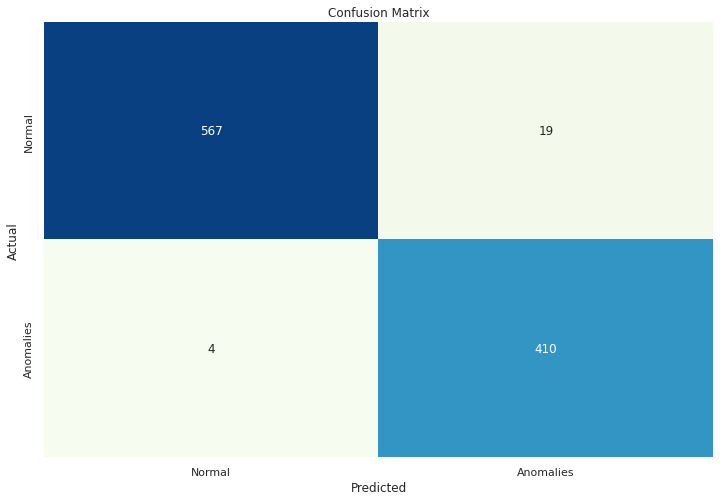

In [151]:
cm = [[pred_normal_true, pred_normal_false], 
      [pred_anomaly_false, pred_anomaly_true]]

# cm = [[pred_anomaly_true, pred_anomaly_false]
#       [pred_normal_false, pred_normal_true]]

categories = ['Normal', 'Anomalies']

g = sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories, 
            yticklabels=categories, 
            cbar=False, 
            cmap="GnBu")

g.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')

plt.show()

Now we combine the first three cells of this block into one as a function which will predict true positives, false negatives, true negatives and false positives. We will need this function to get us values, so we can plot ROC.

In [152]:
def predictor(normal, abnormal, threshold):
   
    # We correctly detect normal data if the normal loss is smaller than the threshold
    pred_normal = tf.math.less(normal, threshold)
    # We correctly detect abnormal data if the normal loss is greater than the threshold
    pred_anomaly = tf.math.greater(abnormal, threshold)

    tn = tf.math.count_nonzero(pred_normal).numpy()
    fp = normal.shape[0] - tn

    tp = tf.math.count_nonzero(pred_anomaly).numpy()
    fn = abnormal.shape[0] - tp
    
    return tp,tn,fp,fn

Calculate the roc values - tpr and fpr...
...first define empty list which will hold the values
...then create a for loop which will take 100 values from 0 to 1 (use np.linspace(from, to, steps))
...now use the defined predictor function and, where the threshold is the value 0 to 1 of the forloop
...calculate the trp and frp for each iteration tpr = tp/(tp + fn) and fpr = fp/(fp + tn)
...append the tpr and fpr values in the roc list

In [153]:
tpr_values = []
fpr_values = []

for thresh in np.linspace(0, 1, 100):
    tp,tn,fp,fn = predictor(test_loss_normal, 
                            test_loss_anomalies, 
                            thresh/10)
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    tpr_values.append(tpr)
    fpr_values.append(fpr)

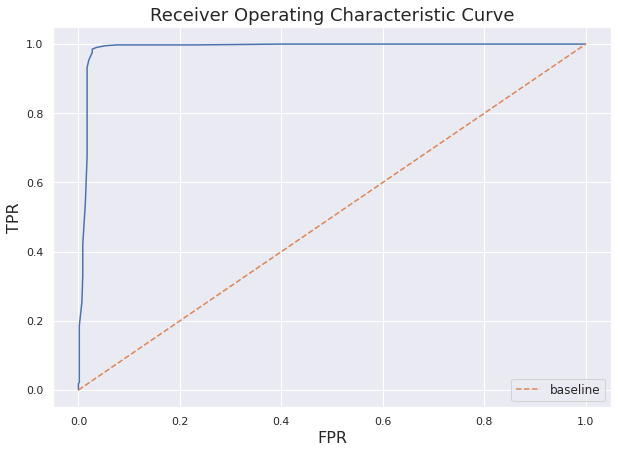

In [154]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);